# Housing prices from Kaggle

### Case Type
* Target is numeric and continuous.
* 80 features (both numeric and categorical)
* Train data has 1460 instances.
* Test data download from Kaggle is not used (not target).

### Goal
To predict housing prices based on its properties.


### Sources
* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/
* https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
* https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
* https://datascience.stackexchange.com/questions/17282/xgbregressor-vs-xgboost-train-huge-speed-difference
* https://www.datacamp.com/community/tutorials/xgboost-in-python
* https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
* https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

### Description
For a description of the data, please see ./data/data_description.txt

### Imports

In [1]:
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics

import xgboost as xgb
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

# Data Preparation

### Load Data

In [2]:
df_raw = pd.read_csv('./data/train.csv', header=0)
print('Dataframe shape is: ', df_raw.shape)
print('Columns are: ', df_raw.columns)
df_raw.head()

Dataframe shape is:  (1460, 81)
Columns are:  Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Subselect the relevant data

In [3]:
cols = ['MSZoning', 'LotArea', 'Street',
        'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearRemodAdd',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
        'GarageArea', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'SalePrice']

df = df_raw[cols]

#To try: 'MSSubClass', 'LotFrontage'
#'Condition1', 'Condition2' - same encoding
#OpenPorchSF + EnclosedPorch

In [4]:
#Inspect data for NaN.
print('Dataframe shape: ', df.shape)
print(df.isna().sum())

Dataframe shape:  (1460, 52)
MSZoning          0
LotArea           0
Street            0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearRemodAdd      0
MasVnrArea        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtFinSF1        0
BsmtFinType2     38
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
FireplaceQu     690
GarageType       81
GarageArea        0
GarageCond       81
PavedDrive        0
WoodDeckSF        0
ScreenPorch

### Inspect NaN data

In [5]:
#Fireplace Quality. Does it relate to places with no fireplace?
df[['FireplaceQu']] = df[['FireplaceQu']].fillna('No_fireplace')

/home/heringer/anaconda2/envs/ml/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<Figure size 720x720 with 0 Axes>

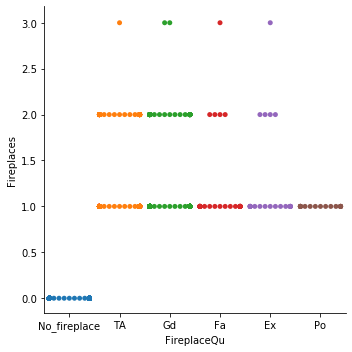

In [6]:
plt.figure(figsize=(10,10))
sns.catplot(x='FireplaceQu', y='Fireplaces', kind="swarm", data=df)
#Indeed, the fireplace quality in the 'FireplaceQu' column is NaN if the house has no fireplace.

<Figure size 720x720 with 0 Axes>

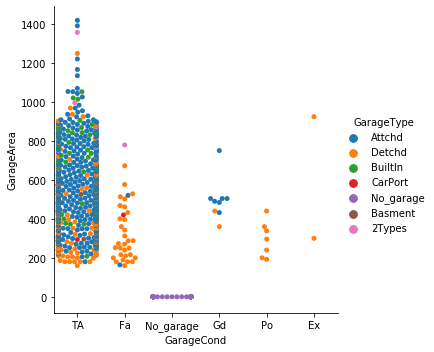

In [7]:
#How does the NaN in GarageCond relate to GarageType and GarageArea
plt.figure(figsize=(10,10))
df[['GarageCond', 'GarageType']] = df[['GarageCond', 'GarageType']].fillna('No_garage')
sns.catplot(x='GarageCond', y='GarageArea', hue='GarageType', kind="swarm", data=df)
#Indeed, NaN in GarageCond and GarageType correspond to a GarageArea of zero.
#We can also see that some GarareType labels are under-represented.

In [8]:
#Basements.
cols = ['BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtFinType2']
df[cols] = df[cols].fillna('No_basement')
#Indeed, the fireplace quality in the 'FireplaceQu' column is NaN if the house has no fireplace.')

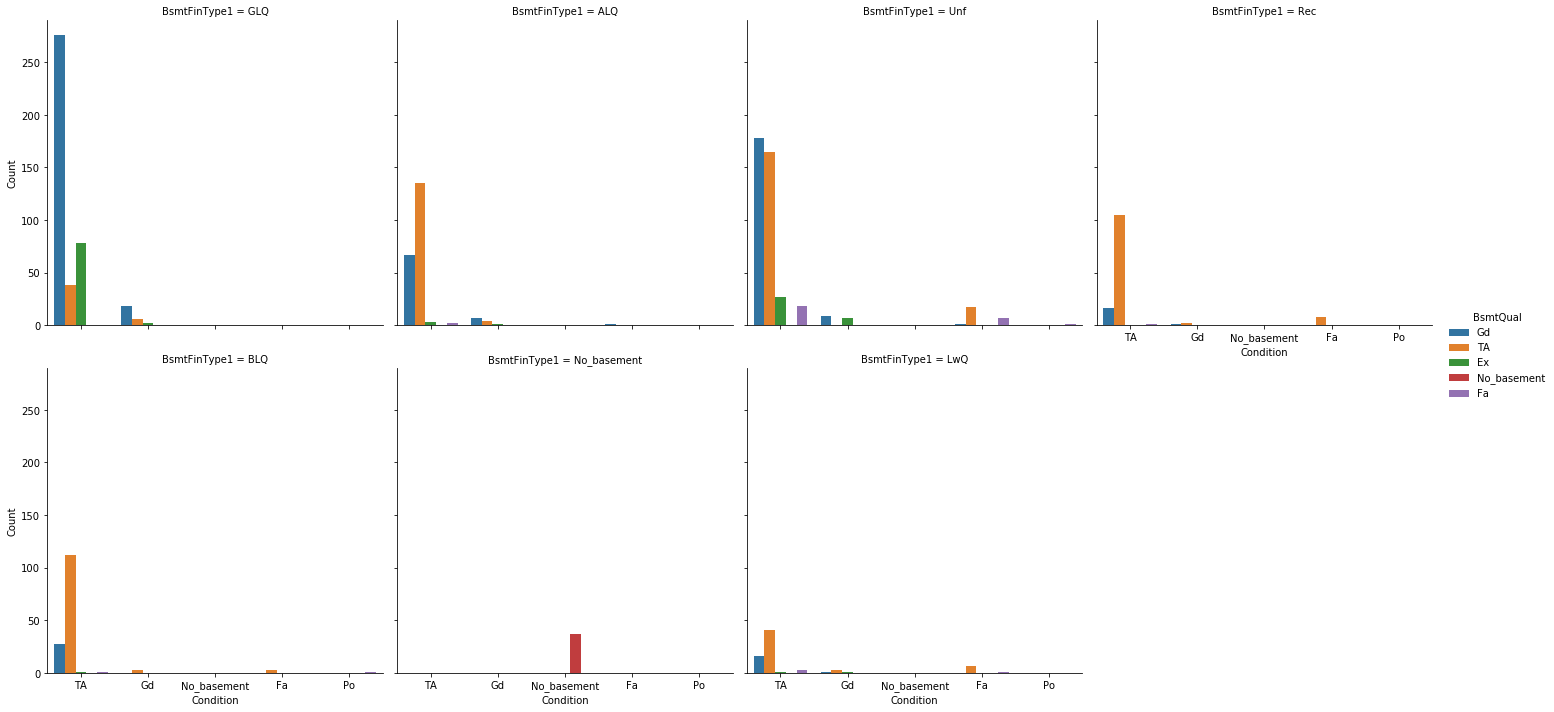

In [9]:
sns.catplot(
  kind='count', data=df, col='BsmtFinType1',
  col_wrap=4, x='BsmtCond', hue='BsmtQual').set_axis_labels("Condition", "Count")

<Figure size 720x720 with 0 Axes>

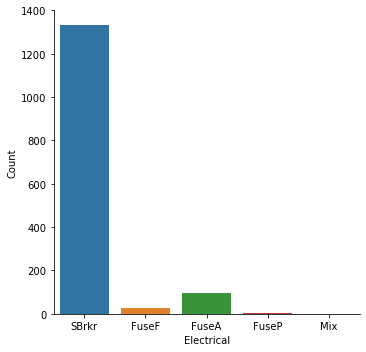

In [10]:
#Electrical
plt.figure(figsize=(10,10))
sns.catplot(kind='count', data=df, x='Electrical').set_axis_labels("Electrical", "Count")
#This does not seem very informative. Drop this feature.

### Inspect the distribution of each variable

In [11]:
#Categorical:

categorical = ['MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'ExterQual', 'ExterCond',  'Foundation', 'BsmtQual', 'BsmtCond',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional',
               'FireplaceQu', 'GarageType', 'GarageCond', 'PavedDrive', 'Electrical']

#Numeric
numeric = ['LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
           'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
           'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
           'Fireplaces', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

In [12]:
print('Number of categorical features: ', len(categorical))
print('Number of numeric features: ', len(numeric))

Number of categorical features:  28
Number of numeric features:  24


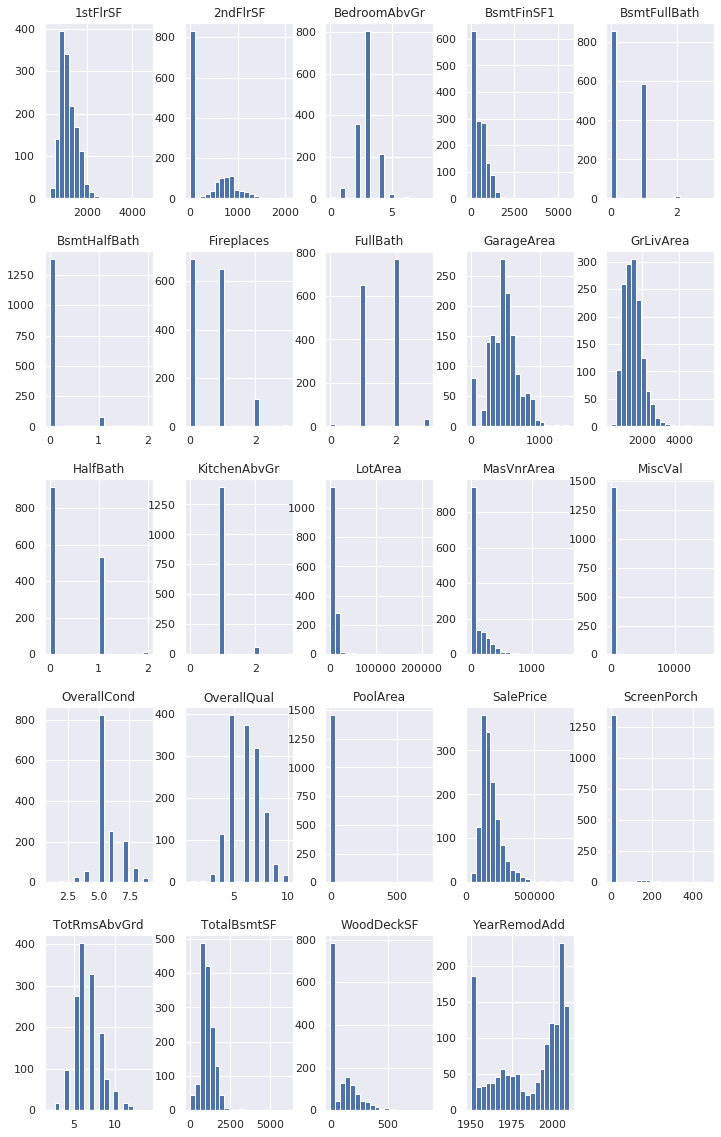

In [13]:
#Show the histogram of all numeric variables. Inspect for outliers and meaningless features.
sns.set(font_scale=1.)
hist = df[numeric].hist(bins=20, figsize=(12,20), layout=(5,5))

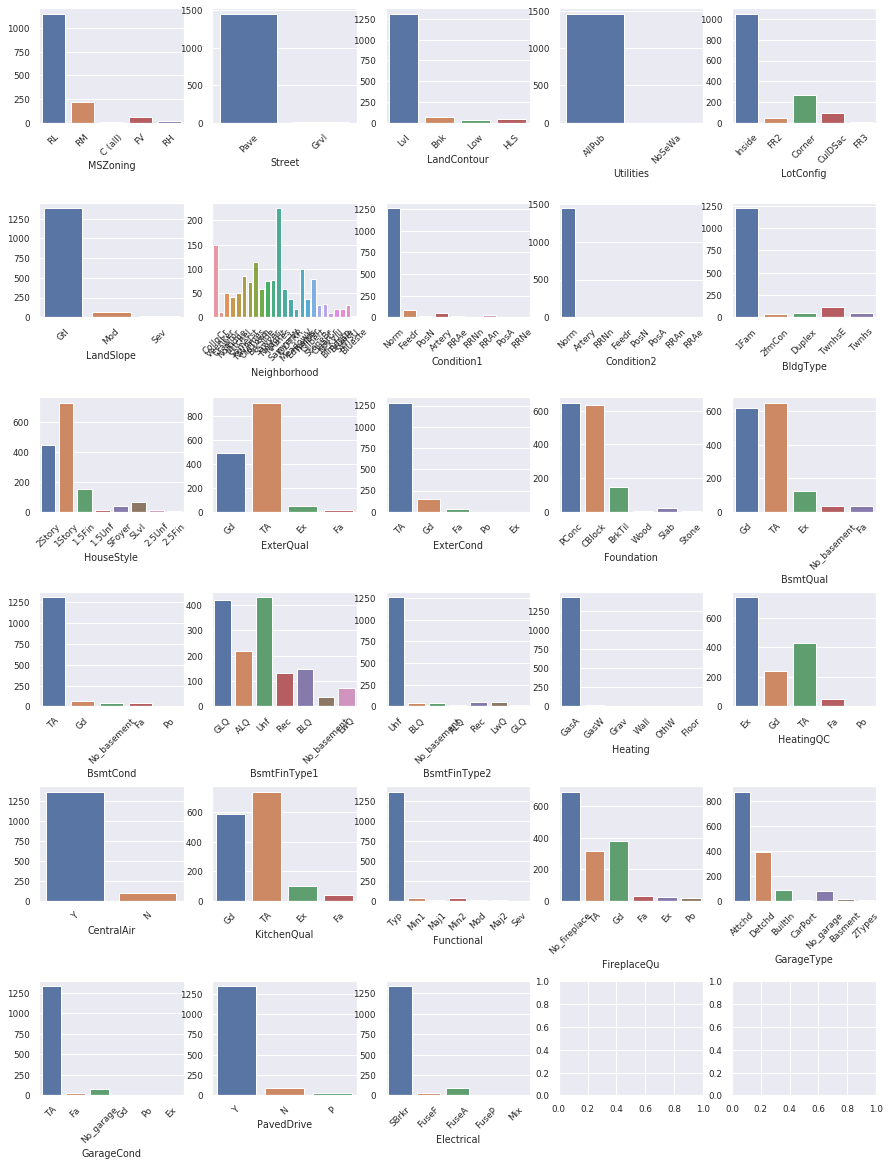

In [14]:
#Show a count of all categorical variables. Inspect for outliers and meaningless features.
#https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
sns.set(font_scale=.8)
fig, ax = plt.subplots(6, 5, figsize=(15, 20))
plt.subplots_adjust(hspace=.7)
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    subplot.set_ylabel('')
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

### Data pre-processing

In [15]:
#Based on the data analyses above, the following are the relevant features.
cat_keep = ['MSZoning', 'LotConfig', 'Neighborhood', 'HouseStyle', 'ExterQual', 'Foundation',
            'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu',
            'GarageType']

num_keep = ['LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea',
            'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
            'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
            'Fireplaces', 'GarageArea', 'WoodDeckSF', 'SalePrice']

In [16]:
#Basic stats
df_aux = df[cat_keep + num_keep]
print('Dataframe reduced shape: ', df_aux.shape)

df_aux = df[cat_keep]
print(df_aux.nunique())

Dataframe reduced shape:  (1460, 32)
MSZoning         5
LotConfig        5
Neighborhood    25
HouseStyle       8
ExterQual        4
Foundation       6
BsmtQual         5
BsmtFinType1     7
HeatingQC        5
CentralAir       2
KitchenQual      4
FireplaceQu      6
GarageType       7
dtype: int64


### Data trimming

In [17]:
def trim_data(_df):
            
    _df_cat = _df[cat_keep].copy()
    _df_num = _df[num_keep].copy()
    
    #Deal with NaN values.
    _df_cat[['FireplaceQu']] = _df_cat[['FireplaceQu']].fillna('No_fireplace')
    _df_cat[['GarageType']] = _df_cat[['GarageType']].fillna('No_garage')
    _df_cat[['BsmtQual', 'BsmtFinType1']] = _df_cat[['BsmtQual', 'BsmtFinType1']].fillna('No_garage')
    
    #Deal with irrelevant labels.
    #Not neeeded for now.  
    return _df_num.copy(), _df_cat.copy()
    #return None

### One-hot Encode categorical features

In [18]:
# encode string input values as integers
def encode_categorical(_df):
    onehotencoder = OneHotEncoder()    
    encoded_array = onehotencoder.fit_transform(_df).toarray()
    _df = pd.DataFrame(encoded_array)
    return _df

### Split the data between train and test sets

In [19]:
#Separate the data into target (y) and features (X)
def split_sample(_df):
    y = _df['SalePrice'].values
    _df.drop(['SalePrice'], axis=1, inplace=True)
    X = _df.values
    Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, test_size=0.2, random_state=0)
    return Train_X, Test_X, Train_y, Test_y

### Data Imputation

In [20]:
def num_imputation(X_train, X_test):
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(X_train)
    X_train = imp_median.transform(X_train)
    X_test = imp_median.transform(X_test)
    return X_train, X_test

### Standardize numeric features

In [21]:
def standardize_numeric(_Train_X, _Test_X):
    scaler = StandardScaler()
    scaler.fit(_Train_X)
    Train_X_scaled = scaler.transform(_Train_X)
    Test_X_scaled = scaler.transform(_Test_X)
    return Train_X_scaled, Test_X_scaled

### Data pre-processing Pipeline

In [22]:
def preproc_data(_df, include):
    df_num, df_cat = trim_data(_df)
    df_cat = encode_categorical(df_cat)
    
    if include == 'all':
        df = pd.concat([df_num, df_cat], axis=1)
    elif include == 'categorical':
        df = df_cat
    elif include == 'numerical':
        df = df_num
        
    Train_X, Test_X, Train_y, Test_y = split_sample(df)
    Train_X, Test_X = num_imputation(Train_X, Test_X)     
    Train_X, Test_X = standardize_numeric(Train_X, Test_X)
    return Train_X, Test_X, Train_y, Test_y

In [23]:
Train_X, Test_X, Train_y, Test_y = preproc_data(df_raw, include='all')

In [24]:
print('Shape of train dataset: ', Train_X.shape)
print('Shape of train target: ', Train_y.shape)
print('Shape of test dataset: ', Test_X.shape)
print('Shape of test target: ', Test_y.shape)

Shape of train dataset:  (1168, 107)
Shape of train target:  (1168,)
Shape of test dataset:  (292, 107)
Shape of test target:  (292,)


### Correlation matrix

(107.0, 0.0)

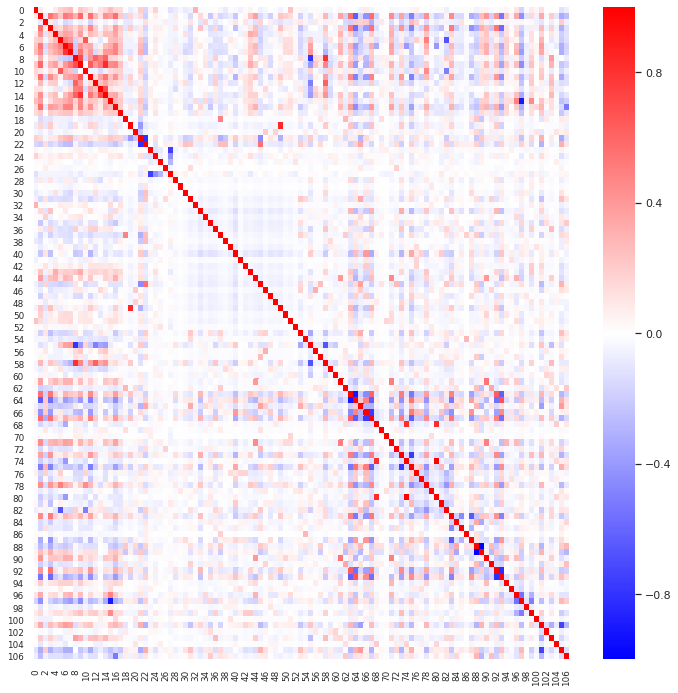

In [25]:
#Investigate the correlation matrix.
df_aux = pd.DataFrame(Train_X)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.)
sns.heatmap(df_aux.corr(), cmap='bwr', ax=ax, vmin=-1., vmax=1.)

#Fix first and last rows. (Bug in recent matplotlib)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [26]:
print(Train_X.max())

34.16138170507822


# Model Testing

### Verbose function

In [27]:
mean_Test_y = np.mean(Test_y)
def print_metrics(_pred_y, _Test_y):
    mse = metrics.mean_squared_error(_pred_y, _Test_y)
    mae = metrics.mean_absolute_error(_pred_y, _Test_y)    
    print('Mean square error: %d' %mse)
    print('Mean absolute error: %d' %mae)
    print('Percent error from mean values: %.2f%%' %(mae/mean_Test_y*100.))

### Use LinearRegression as a benchmark

In [28]:
lr = LinearRegression()
lr.fit(Train_X, Train_y)
pred_y = lr.predict(Test_X)
print_metrics(pred_y, Test_y)

Mean square error: 1919598358
Mean absolute error: 21373
Percent error from mean values: 11.78%


### Ridge Regression

In [29]:
rr = RidgeCV(alphas=np.logspace(-3,2,100), cv=5)
rr.fit(Train_X, Train_y)
pred_y = rr.predict(Test_X)
print_metrics(pred_y, Test_y)

Mean square error: 1875157330
Mean absolute error: 21159
Percent error from mean values: 11.67%


### Lasso Regression

In [30]:
lar = LassoCV(alphas=np.logspace(-3,2,100), cv=5)
lar.fit(Train_X, Train_y)
pred_y = lar.predict(Test_X)
print_metrics(pred_y, Test_y)

Mean square error: 1911291738
Mean absolute error: 21157
Percent error from mean values: 11.67%


### Random Forest

In [31]:
#Define grid for parameter search.
random_grid = {'n_estimators': [int(x) for x in np.logspace(2.3,4,15)],
               'max_features': np.arange(10,21,2),
               'max_depth': np.arange(15,31,5),
               'min_samples_split': np.arange(5,16,5),
               'min_samples_leaf': np.arange(1,11,5)}

In [32]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=0,
                               n_jobs=-1)

rf_random.fit(Train_X, Train_y)
pred_y = rf_random.predict(Test_X)
print_metrics(pred_y, Test_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.0min finished


Mean square error: 1007106468
Mean absolute error: 17460
Percent error from mean values: 9.63%


In [33]:
rf_random.best_params_

{'n_estimators': 4322,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 20,
 'max_depth': 20}

### XGBoost - Complete grid search
Reliable grid search, but takes too long.

In [34]:
xgbr = xgb.XGBRegressor()

parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(Train_X, Train_y)
pred_y = xgb_grid.predict(Test_X)
print_metrics(pred_y, Test_y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   45.0s finished


Mean square error: 769480526
Mean absolute error: 16665
Percent error from mean values: 9.19%


In [35]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

### XGBoost - pair-wise grid search

In [36]:
data_train = xgb.DMatrix(data=Train_X,label=Train_y)
data_test = xgb.DMatrix(data=Test_X,label=Test_y)

In [37]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

params['eval_metric'] = 'mae'
num_boost_round = 999

In [38]:
#Baseline to beat.
model = xgb.train(
    params,
    data_train,
    num_boost_round=num_boost_round,
    evals=[(data_test, "Test")],
    early_stopping_rounds=10,
    verbose_eval=False
)

In [39]:
cv_results = xgb.cv(
    params,
    data_train,
    num_boost_round=num_boost_round,
    seed=0,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results.min()

train-mae-mean     2461.659717
train-mae-std       165.846858
test-mae-mean     18495.458203
test-mae-std       1320.891711
dtype: float64

In [40]:
min_mae = float("Inf")
best_params = None

#Combinations of max_depth and min_child_weight.
gridsearch_params = itertools.product(range(7,12), range(4,8))

for max_depth, min_child_weight in gridsearch_params:
    #print('CV with max_depth={}, min_child_weight={}'.format(max_depth, min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        data_train,
        num_boost_round=num_boost_round,
        seed=0,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    #print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
        
#Updated best parameters
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

/home/heringer/anaconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Best params: 7, 6, MAE: 18108.1992188


In [41]:
min_mae = float("Inf")
best_params = None

#Combinations of subsample and colsample.
gridsearch_params = itertools.product(np.arange(0.6,1.01,0.05),np.arange(0.6,1.01,0.05))

for subsample, colsample in gridsearch_params:
    #print('CV with subsample={}, colsample={}'.format(subsample, colsample))
    # Update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        data_train,
        num_boost_round=num_boost_round,
        seed=0,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    #print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample, colsample)
        
#Updated best parameters
params['subsample'] = best_params[0]
params['colsample'] = best_params[1]
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))


/home/heringer/anaconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Best params: 0.65, 0.8500000000000002, MAE: 17796.980078


In [42]:
min_mae = float("Inf")
best_params = None

for eta in np.logspace(-3.2,-1,20):
    #print('CV with eta={}'.format(eta))
    # Update our parameters
    params['eta'] = eta
    # Run CV
    cv_results = xgb.cv(
        params,
        data_train,
        num_boost_round=num_boost_round,
        seed=0,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    #print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
        
#Updated best parameters
params['eta'] = best_params
print("Best params: {}, MAE: {}".format(best_params, min_mae))


/home/heringer/anaconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Best params: 0.009076005216818141, MAE: 15924.633593800001


In [43]:
xgbr = xgb.XGBRegressor(max_depth=params['max_depth'],
                        min_child_weight=params['min_child_weight'],
                        eta=params['eta'],
                        subsample=params['subsample'],
                        colsample_bytree=params['colsample_bytree'],
                        objective=params['objective'],
                        eval_metric=params['eval_metric'],
                        colsample=params['colsample'])
xgbr.fit(Train_X, Train_y)
pred_y = xgbr.predict(Test_X)
print_metrics(pred_y, Test_y)

Mean square error: 939920799
Mean absolute error: 17659
Percent error from mean values: 9.74%


### Feature Relevance

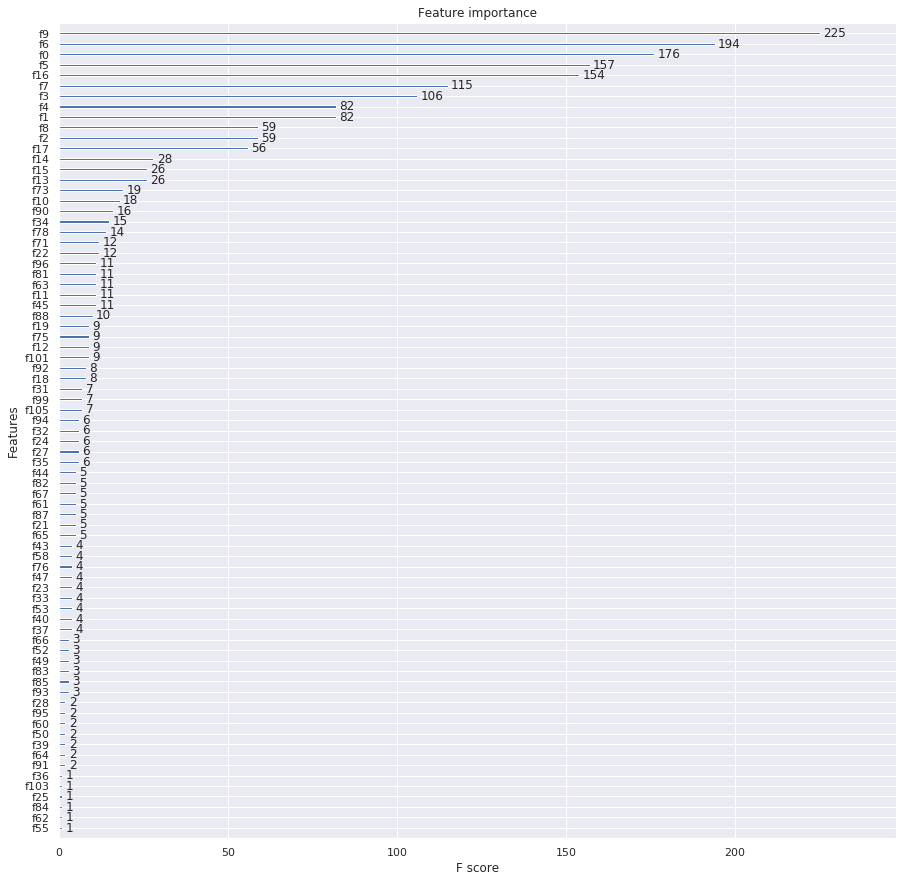

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xgbr, ax=ax)

### Conclusion

* A complete grid search, albeit very modest, produced the best model to make predictions on the Test dataset
  * Mean square error: 769480526
  * Mean absolute error: 16665
  * Percent error from mean values: 9.19%


### Feature Engineering
Apply log transformation to SalesPrice to make it approach a gaussian.

In [45]:
### Feature Selection